## Project Overview

This project develops and compares deep learning models for automated pneumonia detection from chest X-ray images, addressing a critical healthcare challenge that affects millions globally.


## Problem Statement

Pneumoniais a life-threatening respiratory infection that affects one or both lungs, caused by bacteria, viruses, or fungi. It remains the single largest infectious cause of death in children worldwide, claiming the lives of over 800,000 children under five annually (WHO, 2019).

Pneumonia claims over 800,000 young lives annually according to the World Health Organization. The disease requires timely diagnosis through chest X-ray examination, but the shortage of radiologists in many healthcare facilities, particularly in rural and underserved regions, leads to delayed diagnoses and inconsistent interpretations. This diagnostic bottleneck can have life-threatening consequences for patients who need immediate treatment.

This project aims to develop an automated pneumonia detection system using deep learning to assist radiologists in screening chest X-ray images. I will build and compare three different approaches: a custom convolutional neural network, and two transfer learning models using ResNet18 and VGG16 architectures. The goal is to achieve high sensitivity in detecting pneumonia cases, which could help prioritize urgent cases and speed up the diagnostic workflow. 


## Dataset

I used the Chest X-Ray Images dataset from Kaggle, which contains 5,856 pediatric chest X-ray images from Guangzhou Women and Children's Medical Center in China. The dataset is organized into training , validation, and test splits, with two classes: normal and pneumonia, resulting in a 2.70:1 class imbalance.​

All images were collected from patients aged one to five years old and were reviewed by expert physicians to ensure accurate labeling. This dataset has become a widely-used benchmark for pneumonia detection research. 

One notable limitation is the extremely small validation set of only 16 images, which I found challenging for reliable hyperparameter tuning during training.

Source: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [51]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

device = torch.device('mps' if torch.backends.mps.is_available() 
                      else 'cuda' if torch.cuda.is_available() 
                      else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

if device.type == 'mps':
    print("Using Apple Silicon GPU (MPS)")



Using device: mps
PyTorch version: 2.8.0
NumPy version: 2.2.6
Pandas version: 2.3.2
Using Apple Silicon GPU (MPS)


The chest X-ray dataset consists of 5856 total images split into training, validation, and test sets. The dataset shows a notable class imbalance, with pneumonia cases representing 73% of all images (4273 pneumonia vs 1583 normal). The training set contains 5216 images with a pneumonia-to-normal ratio of 2.89:1, while the test set has 624 images with a ratio of 1.67:1.

A significant limitation I noticed is the validation set, which contains only 16 images with 8 normal and 8 pneumonia, this is quite small for reliable model tuning, so I'll rely more heavily on the test set for performance evaluation. 

The imbalance ratio will need to be addressed during model training, by weighted loss functions and data augmentation techniques, to prevent the model from developing a bias toward predicting pneumonia in all cases.


Image counts in each dataset split:
Train: NORMAL=1341, PNEUMONIA=3875, Total=5216, Ratio(P:N)=2.89
Validation: NORMAL=8, PNEUMONIA=8, Total=16, Ratio(P:N)=1.00
Test: NORMAL=234, PNEUMONIA=390, Total=624, Ratio(P:N)=1.67

Overall Dataset Summary:
Total NORMAL images: 1583
Total PNEUMONIA images: 4273
Total images: 5856
Imbalance ratio (Pneumonia:Normal): 2.70
Pneumonia represents 73.0% of the dataset


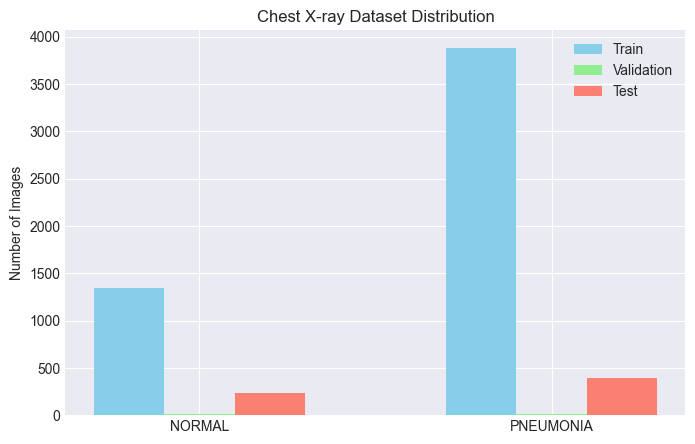

In [52]:
import os
import matplotlib.pyplot as plt

data_dir = './data/chest_xray'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

for name, path in [('Train', train_dir), ('Validation', val_dir), ('Test', test_dir)]:
    if os.path.exists(path):
        pass
    else:
        print(f"{name} directory NOT found at {path}")

def count_images(directory):
    counts = {}
    for category in ['NORMAL', 'PNEUMONIA']:
        category_path = os.path.join(directory, category)
        counts[category] = len([f for f in os.listdir(category_path)])
    return counts

train_counts = count_images(train_dir)
val_counts = count_images(val_dir)
test_counts = count_images(test_dir)

print("\nImage counts in each dataset split:")
for split, counts in [('Train', train_counts), ('Validation', val_counts), ('Test', test_counts)]:
    total = counts['NORMAL'] + counts['PNEUMONIA']
    ratio = counts['PNEUMONIA'] / counts['NORMAL'] if counts['NORMAL'] > 0 else 0
    print(f"{split}: NORMAL={counts['NORMAL']}, PNEUMONIA={counts['PNEUMONIA']}, Total={total}, Ratio(P:N)={ratio:.2f}")

total_normal = train_counts['NORMAL'] + val_counts['NORMAL'] + test_counts['NORMAL']
total_pneumonia = train_counts['PNEUMONIA'] + val_counts['PNEUMONIA'] + test_counts['PNEUMONIA']
total_images = total_normal + total_pneumonia
imbalance_ratio = total_pneumonia / total_normal

print("\nOverall Dataset Summary:")
print(f"Total NORMAL images: {total_normal}")
print(f"Total PNEUMONIA images: {total_pneumonia}")
print(f"Total images: {total_images}")
print(f"Imbalance ratio (Pneumonia:Normal): {imbalance_ratio:.2f}")
print(f"Pneumonia represents {total_pneumonia/total_images*100:.1f}% of the dataset")

labels = ['NORMAL', 'PNEUMONIA']
train_vals = [train_counts['NORMAL'], train_counts['PNEUMONIA']]
val_vals = [val_counts['NORMAL'], val_counts['PNEUMONIA']]
test_vals = [test_counts['NORMAL'], test_counts['PNEUMONIA']]

x = range(len(labels))
plt.figure(figsize=(8,5))
plt.bar([i-0.2 for i in x], train_vals, width=0.2, label='Train', color='skyblue')
plt.bar(x, val_vals, width=0.2, label='Validation', color='lightgreen')
plt.bar([i+0.2 for i in x], test_vals, width=0.2, label='Test', color='salmon')
plt.xticks(x, labels)
plt.ylabel('Number of Images')
plt.title('Chest X-ray Dataset Distribution')
plt.legend()
plt.show()


The bar charts illustrates the distribution of normal and pneumonia cases across training, validation, and test sets. The training data exhibits a pronounced class imbalance with 74.3% pneumonia cases, while the validation set is perfectly balanced but concerningly small at only 16 total images. The test set shows moderate imbalance at 62.5% pneumonia cases.

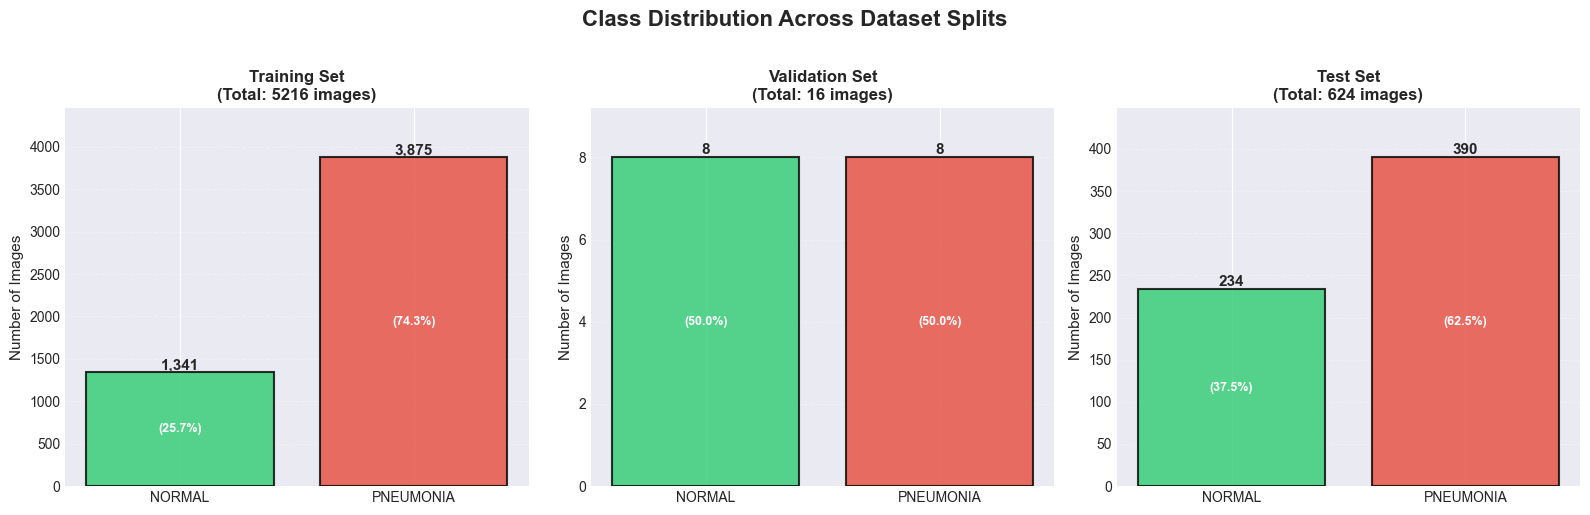

In [53]:

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Class Distribution Across Dataset Splits', 
             fontsize=16, fontweight='bold', y=1.02)

splits = ['Training Set', 'Validation Set', 'Test Set']
counts_list = [train_counts, val_counts, test_counts]
colors = ['#2ecc71', '#e74c3c']  # Green for Normal, Red for Pneumonia

for ax, split, counts in zip(axes, splits, counts_list):
    categories = list(counts.keys())
    values = list(counts.values())
    
    bars = ax.bar(categories, values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    ax.set_title(f'{split}\n(Total: {sum(values)} images)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Images', fontsize=11)
    ax.set_ylim(0, max(values) * 1.15)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    for i, (bar, v) in enumerate(zip(bars, values)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{v:,}',
                ha='center', va='bottom', fontweight='bold', fontsize=11)
        
        pct = v / sum(values) * 100
        ax.text(bar.get_x() + bar.get_width()/2., height * 0.5,
                f'({pct:.1f}%)',
                ha='center', va='center', fontsize=9, color='white', fontweight='bold')

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()



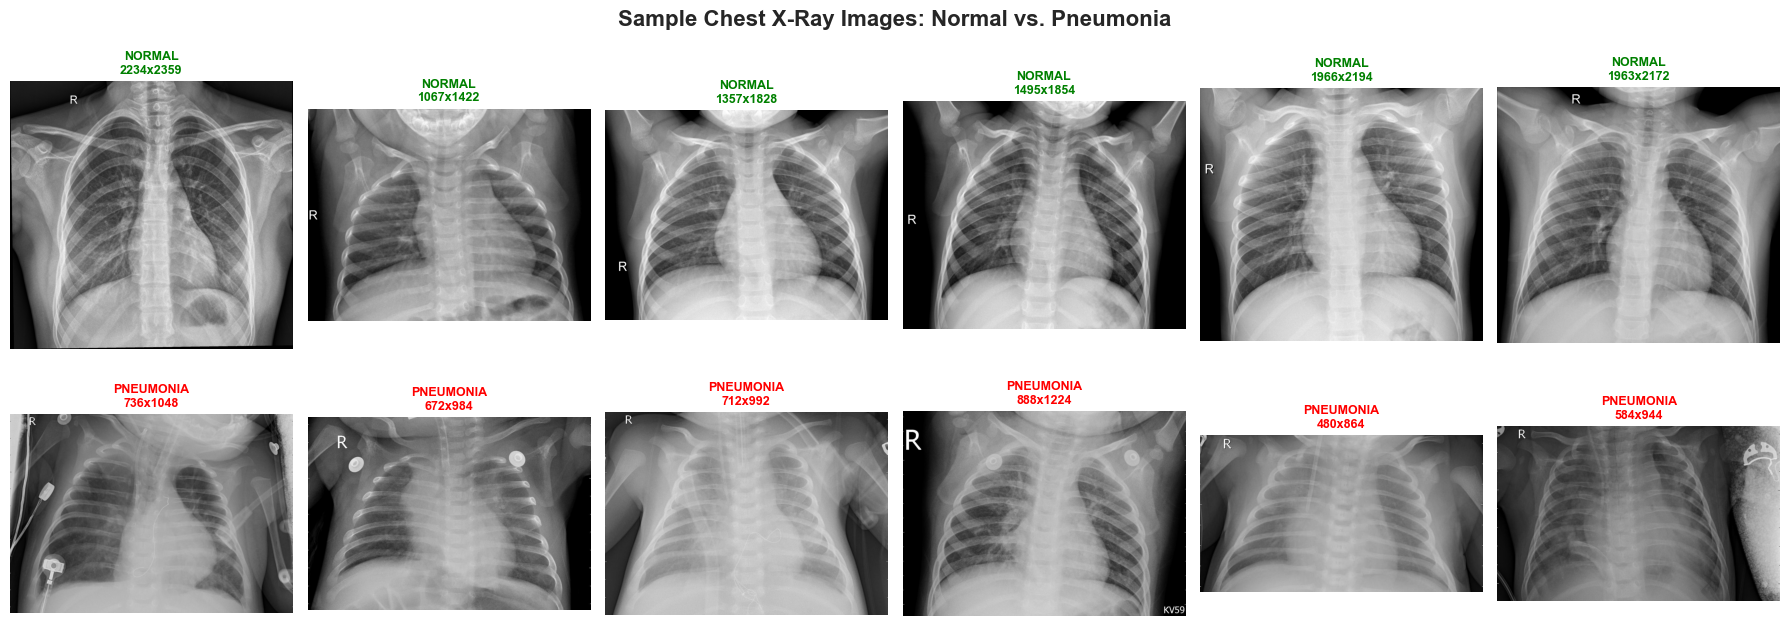

In [54]:

def load_sample_images(directory, category, n_samples=5):
    category_path = os.path.join(directory, category)
    image_files = [f for f in os.listdir(category_path)][:n_samples]
    images = []
    filenames = []
    
    for img_file in image_files:
        img_path = os.path.join(category_path, img_file)
        img = Image.open(img_path).convert('L')  # Convert to grayscale
        images.append(np.array(img))
        filenames.append(img_file)

    
    return images, filenames

normal_samples, normal_files = load_sample_images(train_dir, 'NORMAL', 6)
pneumonia_samples, pneumonia_files = load_sample_images(train_dir, 'PNEUMONIA', 6)

fig, axes = plt.subplots(2, 6, figsize=(18, 7))
fig.suptitle('Sample Chest X-Ray Images: Normal vs. Pneumonia', 
             fontsize=16, fontweight='bold', y=0.98)

# Normal samples
for i, (img, filename) in enumerate(zip(normal_samples, normal_files)):
    axes[0, i].imshow(img, cmap='gray')
    axes[0, i].set_title(f'NORMAL\n{img.shape[0]}x{img.shape[1]}', 
                         fontsize=9, color='green', fontweight='bold')
    axes[0, i].axis('off')

# Pneumonia samples
for i, (img, filename) in enumerate(zip(pneumonia_samples, pneumonia_files)):
    axes[1, i].imshow(img, cmap='gray')
    axes[1, i].set_title(f'PNEUMONIA\n{img.shape[0]}x{img.shape[1]}', 
                         fontsize=9, color='red', fontweight='bold')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()



To better understand the characteristics of the chest X-ray images, I analyzed a random sample of 200 images from each class in the training set, examining five key properties: width, height, aspect ratio, pixel intensity mean, and pixel intensity standard deviation.

It seems pneumonia images are smaller and wider, while normal images are larger and more square. This size variance may require resizing to ensure consistent input dimensions for the model. 


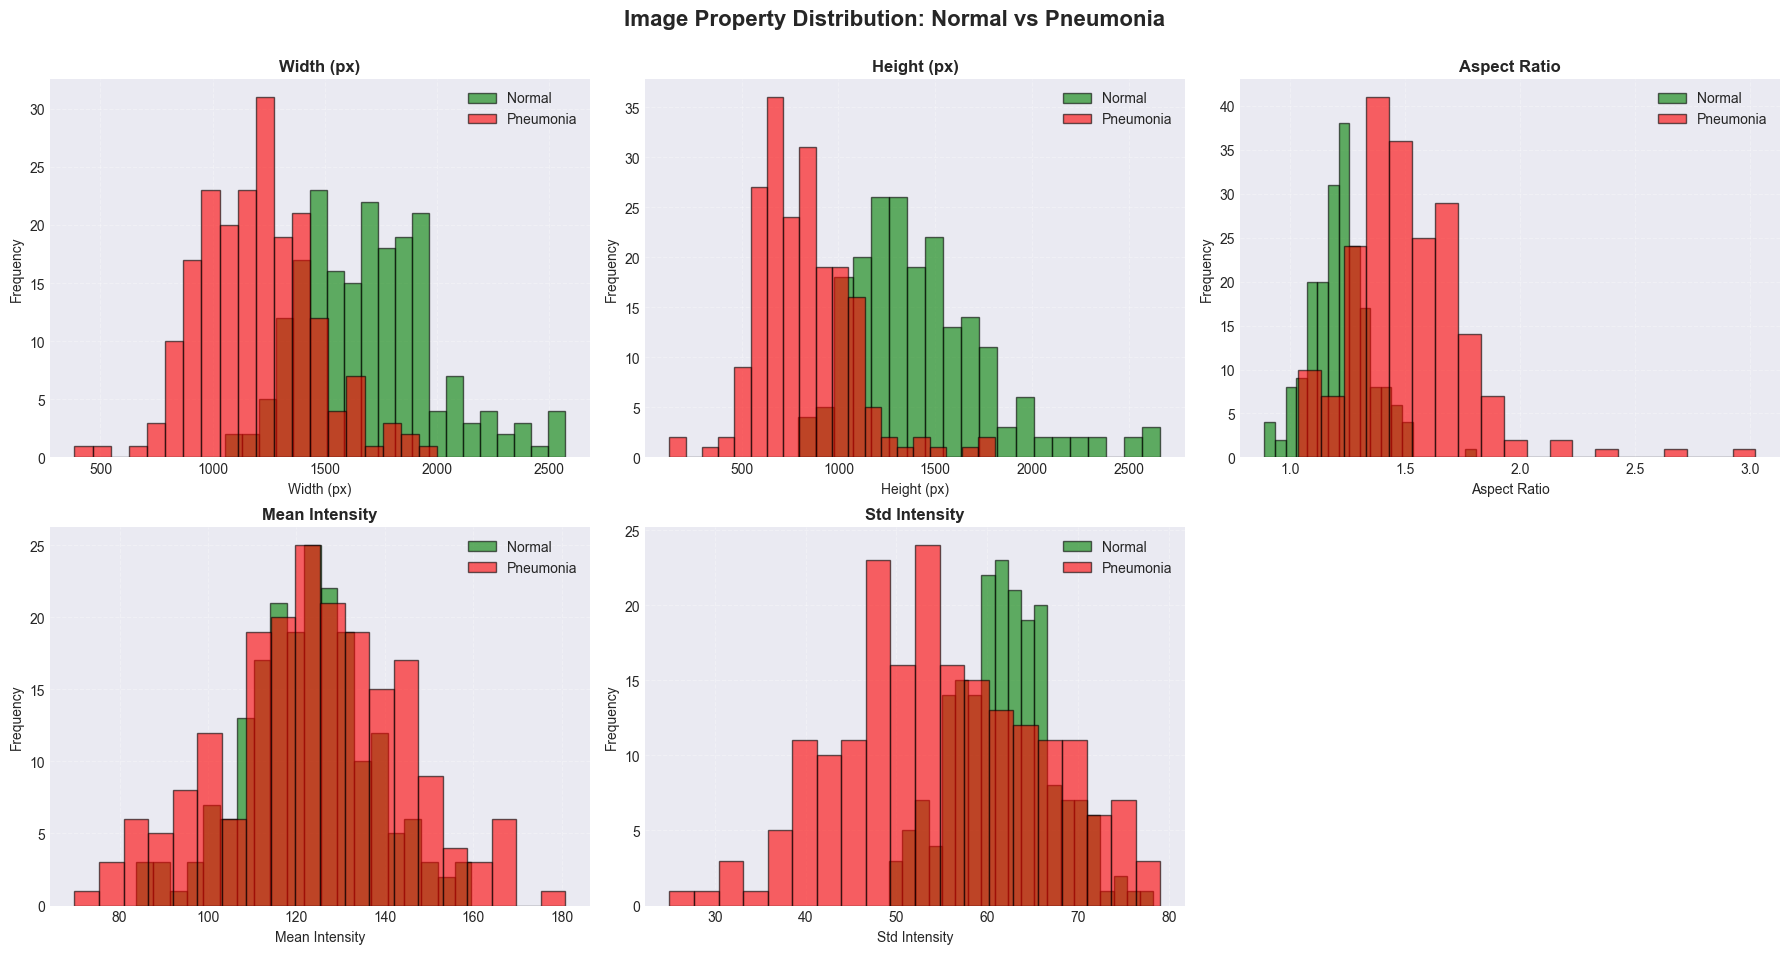


NORMAL Images (n=200)
Property        Mean     Std      Min      Max     
--------------------------------------------------
Widths          1704.38  299.94   1056.00  2572.00 
Heights         1426.45  356.00   792.00   2663.00 
Ratios          1.22     0.13     0.89     1.81    
Means           122.43   14.27    83.78    159.59  
Stds            61.86    5.44     49.19    78.29   

PNEUMONIA Images (n=200)
Property        Mean     Std      Min      Max     
--------------------------------------------------
Widths          1194.68  254.22   384.00   2000.00 
Heights         818.23   243.15   127.00   1806.00 
Ratios          1.51     0.25     1.03     3.02    
Means           123.85   20.84    69.80    180.86  
Stds            54.88    10.89    25.00    79.09   


In [55]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def analyze_images(directory, category, n_samples=200):
    path = os.path.join(directory, category)
    files = [f for f in os.listdir(path)][:n_samples]

    props = {'widths': [], 'heights': [], 'ratios': [], 'means': [], 'stds': []}

    for f in files:
        img = Image.open(os.path.join(path, f)).convert('L')  # grayscale
        arr = np.array(img, dtype=np.float32)
        props['widths'].append(img.width)
        props['heights'].append(img.height)
        props['ratios'].append(img.width / img.height)
        props['means'].append(arr.mean())
        props['stds'].append(arr.std())

    return props

def plot_properties(normal, pneumonia):
    properties = ['widths', 'heights', 'ratios', 'means', 'stds']
    titles = ['Width (px)', 'Height (px)', 'Aspect Ratio', 'Mean Intensity', 'Std Intensity']
    colors = ['green', 'red']

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()

    for i, prop in enumerate(properties):
        axes[i].hist(normal[prop], bins=20, alpha=0.6, label='Normal', color=colors[0], edgecolor='black')
        axes[i].hist(pneumonia[prop], bins=20, alpha=0.6, label='Pneumonia', color=colors[1], edgecolor='black')
        axes[i].set_title(titles[i], fontsize=12, fontweight='bold')
        axes[i].set_xlabel(titles[i])
        axes[i].set_ylabel('Frequency')
        axes[i].legend()
        axes[i].grid(alpha=0.3, linestyle='--')

    axes[-1].axis('off')

    plt.suptitle("Image Property Distribution: Normal vs Pneumonia", fontsize=16, fontweight='bold', y=0.95)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

def print_summary(props, label):
    print(f"\n{label} Images (n={len(props['widths'])})")
    print(f"{'Property':<15} {'Mean':<8} {'Std':<8} {'Min':<8} {'Max':<8}")
    print("-"*50)
    for key in ['widths', 'heights', 'ratios', 'means', 'stds']:
        vals = props[key]
        print(f"{key.title():<15} {np.mean(vals):<8.2f} {np.std(vals):<8.2f} {np.min(vals):<8.2f} {np.max(vals):<8.2f}")


normal_props = analyze_images(train_dir, 'NORMAL', 200)
pneumonia_props = analyze_images(train_dir, 'PNEUMONIA', 200)

plot_properties(normal_props, pneumonia_props)

print_summary(normal_props, "NORMAL")
print_summary(pneumonia_props, "PNEUMONIA")


## Data Preprocessing and Augmentation
To prepare the images for training, I standardized all images to 224×224 pixels to match the input requirements of pre-trained ResNet18 and VGG16 models. Given the significant dimensional variability found in the EDA, this resizing step was essential for consistent neural network inputs.

For the training set, I applied several augmentation techniques to combat overfitting and improve generalization: random horizontal flips (50% probability, which is medically valid for chest X-rays), random rotations (±15°), color jitter for brightness and contrast, and small random translations. I kept these transformations conservative since medical images are more sensitive to distortions than natural images. The validation and test sets received only resizing and normalization to ensure fair evaluation on unmodified data.

All images were normalized using ImageNet statistics (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) to match the pre-training of the transfer learning models.


 Datasets Loaded:
   • Training samples: 5,216
   • Validation samples: 16
   • Test samples: 624
   • Classes: ['NORMAL', 'PNEUMONIA']
   • Class to index: {'NORMAL': 0, 'PNEUMONIA': 1}

 DataLoaders Created:
   • Batch size: 16
   • Training batches: 326
   • Validation batches: 1
   • Test batches: 39


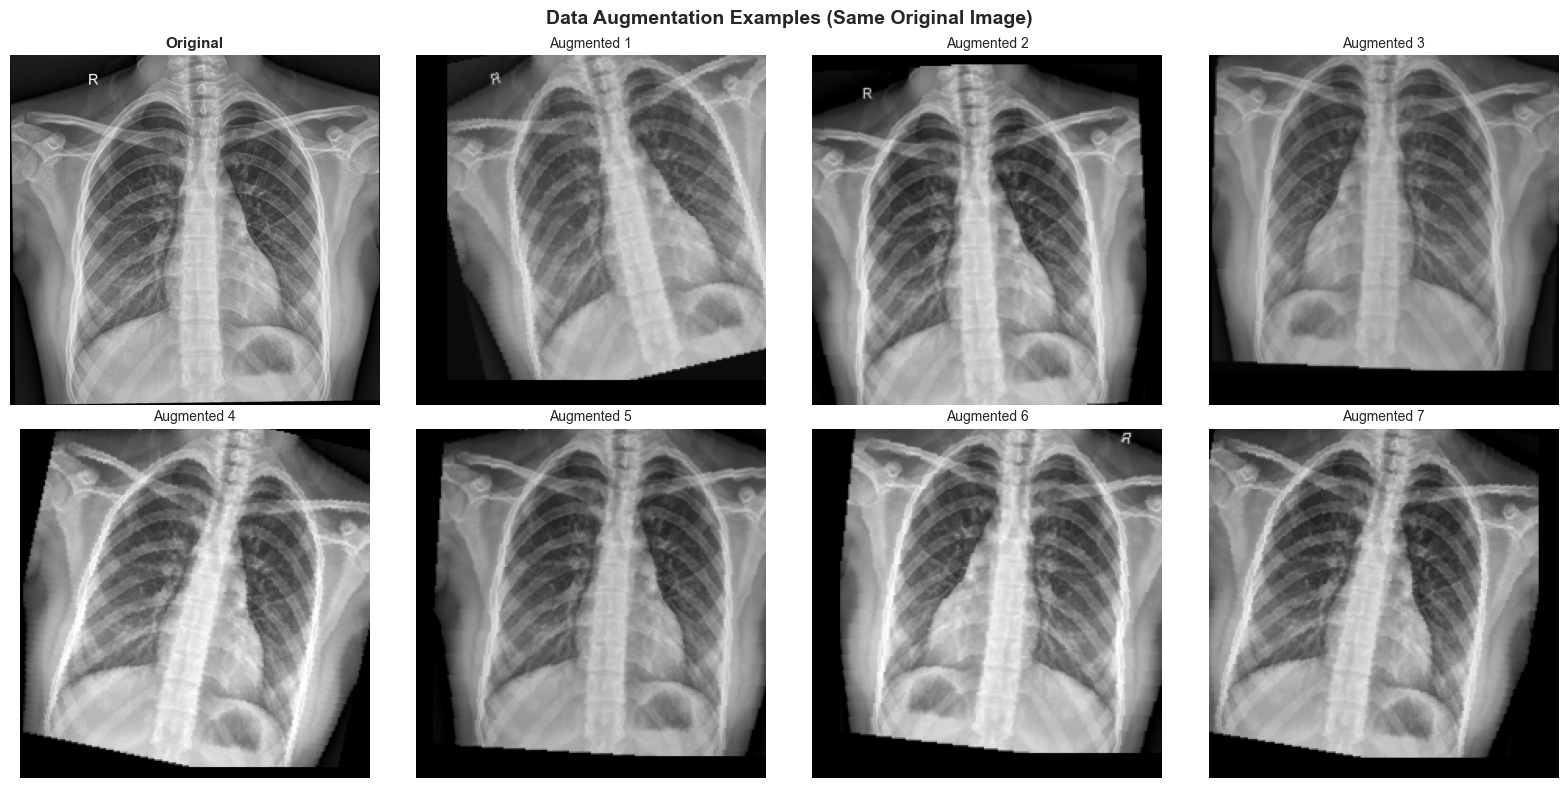

In [56]:


train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Standard input size as the images size varies widely
    transforms.RandomHorizontalFlip(p=0.5),  # X-rays can be flipped
    transforms.RandomRotation(degrees=15),  # Slight rotation for robustness
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Small shifts
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Validation and Test: Only resize and normalize, no augmentation
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transform)

print(f"\n Datasets Loaded:")
print(f"   • Training samples: {len(train_dataset):,}")
print(f"   • Validation samples: {len(val_dataset):,}")
print(f"   • Test samples: {len(test_dataset):,}")
print(f"   • Classes: {train_dataset.classes}")
print(f"   • Class to index: {train_dataset.class_to_idx}")


batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                         shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, 
                       shuffle=False, num_workers=0, pin_memory=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, 
                        shuffle=False, num_workers=0, pin_memory=False)

print(f"\n DataLoaders Created:")
print(f"   • Batch size: {batch_size}")
print(f"   • Training batches: {len(train_loader)}")
print(f"   • Validation batches: {len(val_loader)}")
print(f"   • Test batches: {len(test_loader)}")

# Get one sample image
sample_img_path = os.path.join(train_dir, 'NORMAL', os.listdir(os.path.join(train_dir, 'NORMAL'))[0])
sample_img = Image.open(sample_img_path).convert('RGB')

# Apply augmentation multiple times
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Data Augmentation Examples (Same Original Image)', 
             fontsize=14, fontweight='bold')

axes = axes.flatten()

# Original image
axes[0].imshow(sample_img)
axes[0].set_title('Original', fontsize=11, fontweight='bold')
axes[0].axis('off')

# Augmented images
for idx in range(7):
    augmented = train_transform(sample_img)
    
    # Unnormalize
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    augmented = augmented * std + mean
    augmented = torch.clamp(augmented, 0, 1)
    
    aug_np = augmented.permute(1, 2, 0).numpy()
    
    axes[idx + 1].imshow(aug_np)
    axes[idx + 1].set_title(f'Augmented {idx+1}', fontsize=10)
    axes[idx + 1].axis('off')
plt.tight_layout()
plt.savefig('augmentation_examples.png', dpi=300, bbox_inches='tight')
plt.show()



## Model Architecture Design

To compare different deep learning approaches for pneumonia detection, I implemented three distinct model architectures: a custom CNN built from scratch, and two pre-trained models using transfer learning with ResNet18 and VGG16.

Model 1: Custom CNN, I designed a lightweight convolutional neural network with four convolutional blocks that progressively increase feature channels from 32 to 256 while reducing spatial dimensions through max pooling. Each block includes batch normalization for training stability, ReLU activation for non-linearity. The feature extractor feeds into a fully connected classifier with 512 hidden units and dropout before the final binary classification layer.

Model 2: ResNet18 (Transfer Learning), ResNet18 leverages residual connections to enable deeper networks without vanishing gradients. I froze the early layers and kept only the last 10 parameters trainable to preserve general low-level feature detectors while allowing the model to adapt the high-level features to chest X-rays. The final fully connected layer was replaced to output two classes. 

Model 3: VGG16 (Transfer Learning), VGG16 uses a deeper architecture with 13 convolutional layers arranged in blocks with increasing depth. Similar to ResNet18, I froze early layers and fine-tuned only the final layers, replacing the classifier head for binary pneumonia classification. 

In [57]:
# MODEL 1: Customized CNN 
class CustomCNN(nn.Module):

    def __init__(self, num_classes=2, dropout_rate=0.5):
        super(CustomCNN, self).__init__()
        
        # Convolutional blocks
        self.features = nn.Sequential(
            # Block 1: 3 -> 32
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25),
            
            # Block 2: 32 ->64
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25),
            
            # Block 3: 64 -> 128
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25),
            
            # Block 4: 128 -> 256
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25),
        )
        
        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

# MODEL 2: RESNET18 with transfer learning
def create_resnet18(pretrained=True, num_classes=2, freeze_layers=True):
    model = models.resnet18(pretrained=pretrained)
    
    # Freeze early layers
    if freeze_layers:
        for param in list(model.parameters())[:-10]:
            param.requires_grad = False
    
    # Replace final fully connected layer
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    return model

# MODEL 3: VGG16 with transfer learning
def create_vgg16(pretrained=True, num_classes=2, freeze_layers=True):
    model = models.vgg16(pretrained=pretrained)
    
    # Freeze early layers
    if freeze_layers:
        for param in list(model.parameters())[:-10]:
            param.requires_grad = False
    
    # Replace final classifier layer
    num_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_features, num_classes)
    return model


print("\nMODEL ARCHITECTURE SUMMARY: \n")

# Model 1: Custom CNN
model1_temp = CustomCNN()
total_params_1 = sum(p.numel() for p in model1_temp.parameters())
trainable_params_1 = sum(p.numel() for p in model1_temp.parameters() if p.requires_grad)

print("MODEL 1: CUSTOM CNN")
print(f"Total parameters: {total_params_1:,}")
print(f"Trainable parameters: {trainable_params_1:,} \n")

# Model 2: ResNet18
model2_temp = create_resnet18(pretrained=False, freeze_layers=True)
total_params_2 = sum(p.numel() for p in model2_temp.parameters())
trainable_params_2 = sum(p.numel() for p in model2_temp.parameters() if p.requires_grad)

print("MODEL 2: RESNET18 (Transfer Learning)")
print(f"Total parameters: {total_params_2:,}")
print(f"Trainable parameters: {trainable_params_2:,}")
print(f"Frozen parameters: {total_params_2 - trainable_params_2:,} \n")

# Model 3: VGG16
model3_temp = create_vgg16(pretrained=False, freeze_layers=True)
total_params_3 = sum(p.numel() for p in model3_temp.parameters())
trainable_params_3 = sum(p.numel() for p in model3_temp.parameters() if p.requires_grad)

print("MODEL 3: VGG16 (Transfer Learning)")
print(f"Total parameters: {total_params_3:,}")
print(f"Trainable parameters: {trainable_params_3:,}")
print(f"Frozen parameters: {total_params_3 - trainable_params_3:,}")




MODEL ARCHITECTURE SUMMARY: 

MODEL 1: CUSTOM CNN
Total parameters: 26,081,026
Trainable parameters: 26,081,026 

MODEL 2: RESNET18 (Transfer Learning)
Total parameters: 11,177,538
Trainable parameters: 4,722,690
Frozen parameters: 6,454,848 

MODEL 3: VGG16 (Transfer Learning)
Total parameters: 134,268,738
Trainable parameters: 124,273,666
Frozen parameters: 9,995,072


## Training Methodology

To handle the significant class imbalance in the dataset with 2.7:1 for pneumonia-to-normal ratio, I implemented weighted cross-entropy loss by assigning higher weight to the minority Normal class. This prevents the model from developing a bias toward always predicting the majority Pneumonia class, which is critical in medical applications where both false positives and false negatives have consequences.


In [58]:

class_weights = torch.tensor([imbalance_ratio, 1.0]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

print(f"   Class weights: Normal={class_weights[0]:.3f}, Pneumonia={class_weights[1]:.3f}")

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Print progress every 50 batches
        if (batch_idx + 1) % 50 == 0:
            print(f"   Batch [{batch_idx+1}/{len(dataloader)}] Loss: {loss.item():.4f}")
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc


def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc


def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                num_epochs, device, model_name, patience = 5):
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    best_val_acc = 0.0
    # patience = 5
    patience_counter = 0
    
    for epoch in range(num_epochs):
        print(f"\n Epoch {epoch+1}/{num_epochs}")
        print("-"*70)
        
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Print epoch summary
        print(f"\n Epoch {epoch+1} Summary:")
        print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"   Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
        
        # Learning rate scheduling
        if scheduler:
            old_lr = optimizer.param_groups[0]['lr']
            scheduler.step(val_loss)
            new_lr = optimizer.param_groups[0]['lr']
            if new_lr != old_lr:
                print(f"   Learning rate reduced: {old_lr:.6f} → {new_lr:.6f}")
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'{model_name}_best.pth')
            patience_counter = 0
            print(f"   New best model saved (Val Acc: {val_acc:.2f}%)")
        else:
            patience_counter += 1
            print(f"   Patience: {patience_counter}/{patience}")
        
        # Early stopping
        if patience_counter >= patience:
            print(f"\n Early stopping triggered after {epoch+1} epochs")
            print(f"   Best validation accuracy: {best_val_acc:.2f}%")
            break
    
    print(f"\n {model_name} TRAINING COMPLETE")
    print(f"   Best Validation Accuracy: {best_val_acc:.2f}%")
    
    return history, best_val_acc


   Class weights: Normal=2.699, Pneumonia=1.000


I performed hyperparameter search on CustomCNN testing 5 configurations across learning rates (0.01, 0.001, 0.0001) and dropout values (0.1, 0.3, 0.5). Each configuration trained for 12 epochs with early stopping. 

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import time

# MODEL 1: CUSTOM CNN Hyperparameter Search

configs = [
    {'lr': 0.01,   'dropout': 0.5},
    {'lr': 0.001,  'dropout': 0.1},
    {'lr': 0.001,  'dropout': 0.3},
    {'lr': 0.0001,  'dropout': 0.3},
    {'lr': 0.0001, 'dropout': 0.5},
]

results = []
for i, cfg in enumerate(configs, 1):
    print(f"\nConfig {i}/5: LR={cfg['lr']}, Dropout={cfg['dropout']}")
    
    start = time.time()
    
    model = CustomCNN(dropout_rate=cfg['dropout']).to(device)
    optimizer = optim.Adam(model.parameters(), lr=cfg['lr'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 0.5, 2)

    history, best_acc = train_model(
        model, train_loader, val_loader, criterion,
        optimizer, scheduler, 12, device, f'CNN_Config{i}', patience=2
    )
    
    results.append({
        'Config': i,
        'LR': cfg['lr'],
        'Dropout': cfg['dropout'],
        'Val_Acc': best_acc,
        'Train_Acc': history['train_acc'][-1],
        'Time': (time.time() - start) / 60
    })
    
    print(f"Result: {best_acc:.2f}%")
    
    del model, optimizer
    if hasattr(torch.backends, 'mps'):
        torch.mps.empty_cache()

df = pd.DataFrame(results).sort_values('Val_Acc', ascending=False)

print("\n" + "="*70)
print("RESULTS (Ranked by Performance)")
print("="*70)
print(df.to_string(index=False))




Config 1/5: LR=0.01, Dropout=0.5

 Epoch 1/12
----------------------------------------------------------------------
   Batch [50/326] Loss: 12.7993
   Batch [100/326] Loss: 0.8660
   Batch [150/326] Loss: 0.7482
   Batch [200/326] Loss: 0.5747
   Batch [250/326] Loss: 0.6542
   Batch [300/326] Loss: 1.5150

 Epoch 1 Summary:
   Train Loss: 11.8453 | Train Acc: 61.71%
   Val Loss:   0.5220 | Val Acc:   56.25%
   New best model saved (Val Acc: 56.25%)

 Epoch 2/12
----------------------------------------------------------------------
   Batch [50/326] Loss: 0.7026
   Batch [100/326] Loss: 0.6747
   Batch [150/326] Loss: 0.9190
   Batch [200/326] Loss: 0.3749
   Batch [250/326] Loss: 0.4932
   Batch [300/326] Loss: 0.6515

 Epoch 2 Summary:
   Train Loss: 0.6399 | Train Acc: 75.96%
   Val Loss:   0.7076 | Val Acc:   62.50%
   New best model saved (Val Acc: 62.50%)

 Epoch 3/12
----------------------------------------------------------------------
   Batch [50/326] Loss: 0.6161
   Batch 

I optimized ResNet18's learning rate by testing three values (0.001, 0.0001, 0.00001) while keeping early layers frozen to preserve ImageNet features. Each configuration trained for 12 epochs with early stopping. 

In [60]:
# MODEL 2: RESNET18 Hyperparameter Search

print("HYPERPARAMETER SEARCH - ResNet18")

configs_resnet = [
    {'lr': 0.001,  'freeze': True},
    {'lr': 0.0001, 'freeze': True},
    {'lr': 0.00001,'freeze': True},
]

results_resnet = []
for i, cfg in enumerate(configs_resnet, 1):
    print(f"\nConfig {i}/3: LR={cfg['lr']}, Freeze={cfg['freeze']}")
    
    start = time.time()
    
    model = create_resnet18(pretrained=True, freeze_layers=cfg['freeze']).to(device)
    optimizer = optim.Adam(model.parameters(), lr=cfg['lr'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 0.5, 2)
    
    history, best_acc = train_model(
        model, train_loader, val_loader, criterion,
        optimizer, scheduler, 12, device, f'ResNet_Config{i}', patience=2
    )
    
    results_resnet.append({
        'Config': i,
        'LR': cfg['lr'],
        'Freeze': cfg['freeze'],
        'Val_Acc': best_acc,
        'Train_Acc': history['train_acc'][-1],
        'Time': (time.time() - start) / 60
    })
    
    print(f"Result: {best_acc:.2f}%")
    
    del model, optimizer
    if hasattr(torch.backends, 'mps'):
        torch.mps.empty_cache()

df_resnet = pd.DataFrame(results_resnet).sort_values('Val_Acc', ascending=False)

print("\n" + "="*70)
print("ResNet18 RESULTS")
print("="*70)
print(df_resnet.to_string(index=False))


HYPERPARAMETER SEARCH - ResNet18

Config 1/3: LR=0.001, Freeze=True

 Epoch 1/12
----------------------------------------------------------------------
   Batch [50/326] Loss: 0.0173
   Batch [100/326] Loss: 0.2875
   Batch [150/326] Loss: 0.0252
   Batch [200/326] Loss: 0.1309
   Batch [250/326] Loss: 0.2381
   Batch [300/326] Loss: 0.1740

 Epoch 1 Summary:
   Train Loss: 0.2012 | Train Acc: 92.94%
   Val Loss:   0.7254 | Val Acc:   81.25%
   New best model saved (Val Acc: 81.25%)

 Epoch 2/12
----------------------------------------------------------------------
   Batch [50/326] Loss: 0.0510
   Batch [100/326] Loss: 0.0162
   Batch [150/326] Loss: 0.0300
   Batch [200/326] Loss: 0.0257
   Batch [250/326] Loss: 0.0255
   Batch [300/326] Loss: 0.0744

 Epoch 2 Summary:
   Train Loss: 0.1311 | Train Acc: 95.00%
   Val Loss:   0.5330 | Val Acc:   93.75%
   New best model saved (Val Acc: 93.75%)

 Epoch 3/12
----------------------------------------------------------------------
   Batch

I conducted learning rate optimization for VGG16 using the same strategy as ResNet18, testing values of 0.001, 0.0001, and 0.00001 while maintaining frozen early layers. 

In [61]:
# MODEL 3: VGG16 HYPERPARAMETER SEARCH

print("HYPERPARAMETER SEARCH - VGG16")

configs_vgg = [
    {'lr': 0.001,  'freeze': True},
    {'lr': 0.0001, 'freeze': True},
    {'lr': 0.00001,'freeze': True},
]

results_vgg = []
for i, cfg in enumerate(configs_vgg, 1):
    print(f"\nConfig {i}/3: LR={cfg['lr']}, Freeze={cfg['freeze']}")
    
    start = time.time()
    
    model = create_vgg16(pretrained=True, freeze_layers=cfg['freeze']).to(device)
    optimizer = optim.Adam(model.parameters(), lr=cfg['lr'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 0.5, 2)
    
    history, best_acc = train_model(
        model, train_loader, val_loader, criterion,
        optimizer, scheduler, 12, device, f'VGG_Config{i}', patience=2
    )
    
    results_vgg.append({
        'Config': i,
        'LR': cfg['lr'],
        'Freeze': cfg['freeze'],
        'Val_Acc': best_acc,
        'Train_Acc': history['train_acc'][-1],
        'Time': (time.time() - start) / 60
    })
    
    print(f"Result: {best_acc:.2f}%")
    
    del model, optimizer
    if hasattr(torch.backends, 'mps'):
        torch.mps.empty_cache()

df_vgg = pd.DataFrame(results_vgg).sort_values('Val_Acc', ascending=False)

print("\n" + "="*70)
print("VGG16 RESULTS")
print("="*70)
print(df_vgg.to_string(index=False))

HYPERPARAMETER SEARCH - VGG16

Config 1/3: LR=0.001, Freeze=True

 Epoch 1/12
----------------------------------------------------------------------
   Batch [50/326] Loss: 0.9152
   Batch [100/326] Loss: 0.8952
   Batch [150/326] Loss: 0.0833
   Batch [200/326] Loss: 0.3601
   Batch [250/326] Loss: 0.3251
   Batch [300/326] Loss: 0.1791

 Epoch 1 Summary:
   Train Loss: 0.4795 | Train Acc: 85.28%
   Val Loss:   0.4280 | Val Acc:   75.00%
   New best model saved (Val Acc: 75.00%)

 Epoch 2/12
----------------------------------------------------------------------
   Batch [50/326] Loss: 0.0332
   Batch [100/326] Loss: 1.9869
   Batch [150/326] Loss: 1.0082
   Batch [200/326] Loss: 0.6113
   Batch [250/326] Loss: 0.5125
   Batch [300/326] Loss: 0.0984

 Epoch 2 Summary:
   Train Loss: 0.3972 | Train Acc: 87.38%
   Val Loss:   0.4485 | Val Acc:   68.75%
   Patience: 1/2

 Epoch 3/12
----------------------------------------------------------------------
   Batch [50/326] Loss: 0.5711
   Ba

## Model Training and Comparison

I trained three distinct deep learning architectures to compare their effectiveness for pneumonia detection from chest X-rays. The training process used consistent methodology across all models to ensure fair comparison, with appropriate hyperparameter adjustments based on each architecture's training approach.

CustomCNN was trained from scratch for 20 epochs using a learning rate of 0.001, allowing the model to learn all features directly from the medical imaging dataset. This baseline model achieved solid performance while providing insight into what can be accomplished without pre-trained knowledge. Training from scratch requires higher learning rates and more epochs compared to transfer learning approaches since the model must learn both low-level edge detection and high-level disease patterns simultaneously.

ResNet18 leveraged transfer learning with ImageNet pre-trained weights, training for 15 epochs with a significantly lower learning rate of 0.0001. The early layers remained frozen to preserve general feature detectors learned from millions of natural images, while the final layers were fine-tuned specifically for pneumonia classification. This approach converged faster than training from scratch and achieved superior performance, demonstrating that transfer learning effectively bridges the domain gap between natural images and medical imaging.

VGG16 similarly employed transfer learning with frozen early layers and a learning rate of 0.0001, trained for 15 epochs. 

In [62]:

all_results = {}

print("  MODEL 1: CUSTOM CNN")

model1 = CustomCNN(dropout_rate=0.3).to(device)
optimizer1 = optim.Adam(model1.parameters(), lr=0.0001)
scheduler1 = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer1, mode='min', factor=0.5, patience=2
)

history1, best_acc1 = train_model(
    model1, train_loader, val_loader, criterion, optimizer1, scheduler1,
    num_epochs=20, device=device, model_name='CustomCNN'
)

all_results['CustomCNN'] = {
    'history': history1, 
    'best_val_acc': best_acc1,
    'model': model1
}

# TRAIN MODEL 2: RESNET18

print("\n\n")
print("  MODEL 2: RESNET18 (TRANSFER LEARNING)")

model2 = create_resnet18(pretrained=True, freeze_layers=True).to(device)
optimizer2 = optim.Adam(model2.parameters(), lr=0.0001)
scheduler2 = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer2, mode='min', factor=0.5, patience=2
)

history2, best_acc2 = train_model(
    model2, train_loader, val_loader, criterion, optimizer2, scheduler2,
    num_epochs=15, device=device, model_name='ResNet18'
)

all_results['ResNet18'] = {
    'history': history2, 
    'best_val_acc': best_acc2,
    'model': model2
}

# TRAIN MODEL 3: VGG16
print("\n\n")
print("  MODEL 3: VGG16 (TRANSFER LEARNING)")

model3 = create_vgg16(pretrained=True, freeze_layers=True).to(device)
optimizer3 = optim.Adam(model3.parameters(), lr=0.0001)
scheduler3 = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer3, mode='min', factor=0.5, patience=2
)

history3, best_acc3 = train_model(
    model3, train_loader, val_loader, criterion, optimizer3, scheduler3,
    num_epochs=15, device=device, model_name='VGG16'
)

all_results['VGG16'] = {
    'history': history3, 
    'best_val_acc': best_acc3,
    'model': model3
}

# TRAINING SUMMARY

print("\n\n")
print(" ALL MODELS TRAINED SUCCESSFULLY!")

summary_data = []
for model_name in ['CustomCNN', 'ResNet18', 'VGG16']:
    summary_data.append({
        'Model': model_name,
        'Best Val Acc (%)': all_results[model_name]['best_val_acc'],
        'Final Train Acc (%)': all_results[model_name]['history']['train_acc'][-1],
        'Epochs Trained': len(all_results[model_name]['history']['train_loss'])
    })

summary_df = pd.DataFrame(summary_data)
print("\n Training Summary:\n")
print(summary_df.to_string(index=False))

best_model_name = max(all_results, key=lambda x: all_results[x]['best_val_acc'])
print(f"\n Best Model: {best_model_name} ({all_results[best_model_name]['best_val_acc']:.2f}% val acc)")


  MODEL 1: CUSTOM CNN

 Epoch 1/20
----------------------------------------------------------------------
   Batch [50/326] Loss: 0.8497
   Batch [100/326] Loss: 1.0901
   Batch [150/326] Loss: 0.2987
   Batch [200/326] Loss: 0.3096
   Batch [250/326] Loss: 0.3399
   Batch [300/326] Loss: 0.3549

 Epoch 1 Summary:
   Train Loss: 0.5273 | Train Acc: 77.43%
   Val Loss:   0.8478 | Val Acc:   68.75%
   New best model saved (Val Acc: 68.75%)

 Epoch 2/20
----------------------------------------------------------------------
   Batch [50/326] Loss: 0.3262
   Batch [100/326] Loss: 0.4607
   Batch [150/326] Loss: 0.6854
   Batch [200/326] Loss: 0.1637
   Batch [250/326] Loss: 0.1799
   Batch [300/326] Loss: 0.3942

 Epoch 2 Summary:
   Train Loss: 0.3558 | Train Acc: 84.91%
   Val Loss:   0.8486 | Val Acc:   62.50%
   Patience: 1/5

 Epoch 3/20
----------------------------------------------------------------------
   Batch [50/326] Loss: 0.5234
   Batch [100/326] Loss: 0.4352
   Batch [150/32

## Training Analysis
The training history  reveal distinct learning behaviors across the three models. 

CustomCNN shows steady convergence with both training and validation losses decreasing smoothly over 6 epochs. The model benefits from the full training regimen since it's learning from scratch without pre-trained weights.​

ResNet18 demonstrates the most volatile training pattern with early stopping triggered after 8 epochs. The validation loss curve shows significant fluctuation, spiking dramatically at epochs 6 and 9, which indicates instability likely caused by the extremely small validation set (only 16 images). Despite this, training loss decreases consistently and the model achieves near-perfect training accuracy (97%) by the end, though validation accuracy plateaus around 80%. The divergence between training and validation metrics suggests potential overfitting, though the tiny validation set makes this assessment less reliable.​

VGG16 exhibits the fastest convergence, reaching optimal performance within just 6 epochs before early stopping. The validation loss increases after epoch 1 while training loss continues to decrease, which is a classic sign of overfitting. The model achieves high training accuracy (~97%) but validation accuracy fluctuates between 80-100%, again highlighting the unreliability of the small validation set. The rapid convergence suggests that VGG16's deeper architecture and pre-trained features capture relevant patterns quickly, though the overfitting indicates the model may be too complex for this relatively small medical imaging dataset.

 CREATING TRAINING VISUALIZATIONS


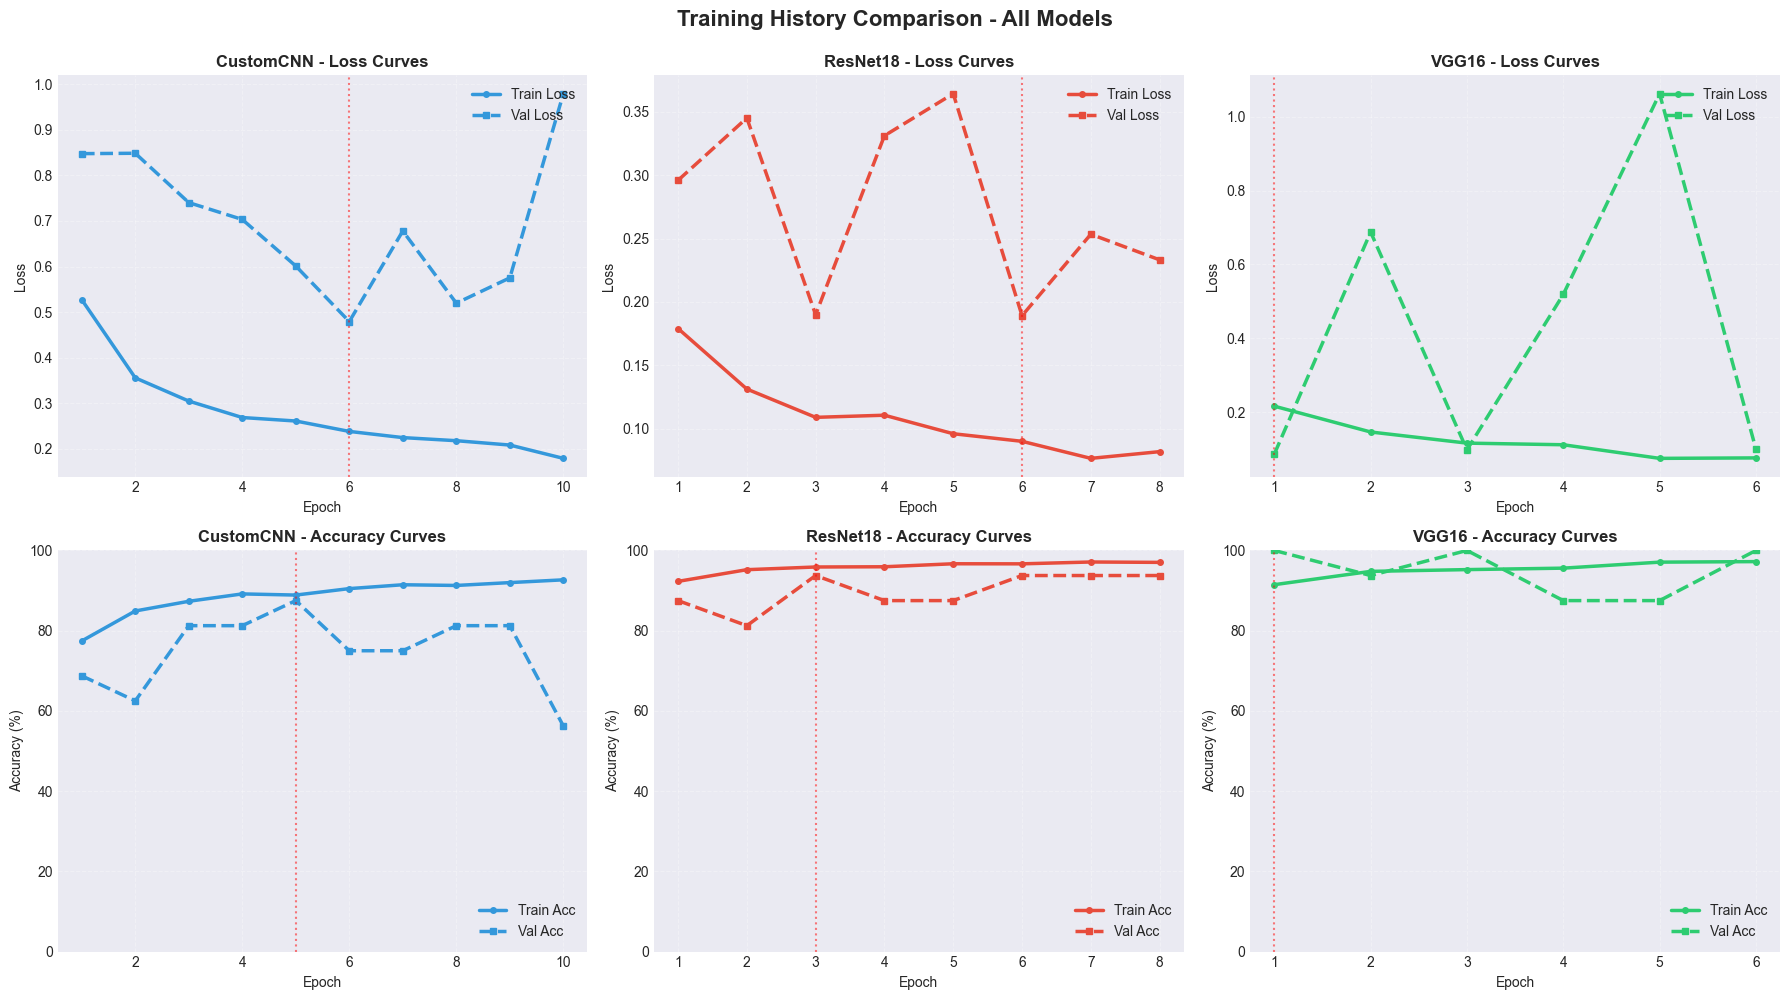

In [63]:

print(" CREATING TRAINING VISUALIZATIONS")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Training History Comparison - All Models', 
             fontsize=16, fontweight='bold', y=0.995)

models_list = ['CustomCNN', 'ResNet18', 'VGG16']
colors = ['#3498db', '#e74c3c', '#2ecc71']

for idx, (model_name, color) in enumerate(zip(models_list, colors)):
    history = all_results[model_name]['history']
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss plot 
    ax_loss = axes[0, idx]
    ax_loss.plot(epochs, history['train_loss'], 
                label='Train Loss', color=color, linewidth=2.5, marker='o', markersize=4)
    ax_loss.plot(epochs, history['val_loss'], 
                label='Val Loss', color=color, linestyle='--', linewidth=2.5, marker='s', markersize=4)
    ax_loss.set_title(f'{model_name} - Loss Curves', fontsize=12, fontweight='bold')
    ax_loss.set_xlabel('Epoch', fontsize=10)
    ax_loss.set_ylabel('Loss', fontsize=10)
    ax_loss.legend(loc='upper right')
    ax_loss.grid(alpha=0.3, linestyle='--')
    
    # Highlight best epoch
    best_epoch = np.argmin(history['val_loss'])
    ax_loss.axvline(x=best_epoch+1, color='red', linestyle=':', alpha=0.5, label='Best Epoch')
    
    # Accuracy plot
    ax_acc = axes[1, idx]
    ax_acc.plot(epochs, history['train_acc'], 
               label='Train Acc', color=color, linewidth=2.5, marker='o', markersize=4)
    ax_acc.plot(epochs, history['val_acc'], 
               label='Val Acc', color=color, linestyle='--', linewidth=2.5, marker='s', markersize=4)
    ax_acc.set_title(f'{model_name} - Accuracy Curves', fontsize=12, fontweight='bold')
    ax_acc.set_xlabel('Epoch', fontsize=10)
    ax_acc.set_ylabel('Accuracy (%)', fontsize=10)
    ax_acc.legend(loc='lower right')
    ax_acc.grid(alpha=0.3, linestyle='--')
    ax_acc.set_ylim([0, 100])
    
    # Highlight best epoch
    best_epoch_acc = np.argmax(history['val_acc'])
    ax_acc.axvline(x=best_epoch_acc+1, color='red', linestyle=':', alpha=0.5, label='Best Epoch')

plt.tight_layout()
plt.savefig('training_history_comparison.png', dpi=300, bbox_inches='tight')
plt.show()



ResNet18 emerges as the best overall performer with 91.83% accuracy and the highest ROC AUC score of 0.9654, indicating excellent discriminative ability. Most importantly for pneumonia screening, it achieves 96.41% sensitivity, meaning it correctly identifies 96.41% of pneumonia cases – this is critical in medical applications where missing a true pneumonia diagnosis (false negatives) could delay life-saving treatment. However, this comes at the cost of slightly lower specificity (84.19%), meaning some healthy patients may be flagged as potentially having pneumonia.

VGG16 achieves the highest sensitivity at 96.92%, catching nearly all pneumonia cases, but has the lowest specificity (72.22%), resulting in more false positives. This means VGG16 is very cautious and tends to flag borderline cases as pneumonia, which could lead to unnecessary follow-up tests but ensures fewer missed diagnoses. Its overall accuracy of 87.66% and ROC AUC of 0.9544 remain strong.

CustomCNN shows the most balanced performance with 82.53% accuracy, 80.77% sensitivity, and 85.47% specificity. While it doesn't excel in any single metric, it demonstrates that a relatively simple architecture trained from scratch can achieve reasonable pneumonia detection without transfer learning

In [64]:
# TEST SET EVALUATION

def evaluate_model(model, test_loader, device, model_name):
    model.eval()
    
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='binary', pos_label=1
    )
    
    cm = confusion_matrix(all_labels, all_preds)
    fpr, tpr, _ = roc_curve(all_labels, all_probs[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Calculate sensitivity and specificity
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)  # Same as recall
    specificity = tn / (tn + fp)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'confusion_matrix': cm,
        'roc_auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs
    }

print("EVALUATING ALL MODELS ON TEST SET")

evaluation_results = {}

for model_name in models_list:
    print(f"\n Evaluating {model_name}...")
    
    # Load best model
    if model_name == 'CustomCNN':
        model = CustomCNN().to(device)
    elif model_name == 'ResNet18':
        model = create_resnet18(pretrained=False).to(device)
    else:
        model = create_vgg16(pretrained=False).to(device)
    
    model.load_state_dict(torch.load(f'{model_name}_best.pth'))
    
    results = evaluate_model(model, test_loader, device, model_name)
    evaluation_results[model_name] = results
    
    print(f"\n {model_name} Test Set Performance:")
    print(f"   Accuracy:    {results['accuracy']*100:.2f}%")
    print(f"   Precision:   {results['precision']*100:.2f}%")
    print(f"   Recall:      {results['recall']*100:.2f}%")
    print(f"   F1-Score:    {results['f1']*100:.2f}%")
    print(f"   Sensitivity: {results['sensitivity']*100:.2f}%")
    print(f"   Specificity: {results['specificity']*100:.2f}%")
    print(f"   ROC AUC:     {results['roc_auc']:.4f}")



EVALUATING ALL MODELS ON TEST SET

 Evaluating CustomCNN...

 CustomCNN Test Set Performance:
   Accuracy:    87.50%
   Precision:   89.59%
   Recall:      90.51%
   F1-Score:    90.05%
   Sensitivity: 90.51%
   Specificity: 82.48%
   ROC AUC:     0.9443

 Evaluating ResNet18...

 ResNet18 Test Set Performance:
   Accuracy:    92.15%
   Precision:   92.95%
   Recall:      94.62%
   F1-Score:    93.77%
   Sensitivity: 94.62%
   Specificity: 88.03%
   ROC AUC:     0.9685

 Evaluating VGG16...

 VGG16 Test Set Performance:
   Accuracy:    90.87%
   Precision:   91.52%
   Recall:      94.10%
   F1-Score:    92.79%
   Sensitivity: 94.10%
   Specificity: 85.47%
   ROC AUC:     0.9588


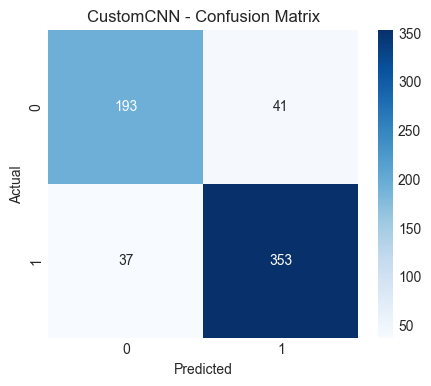

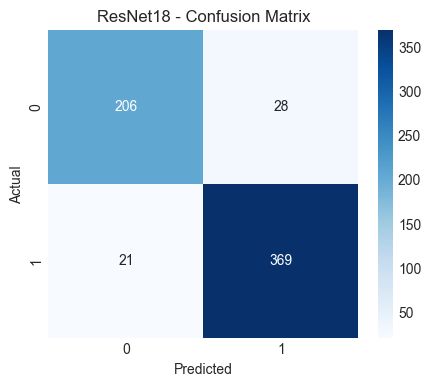

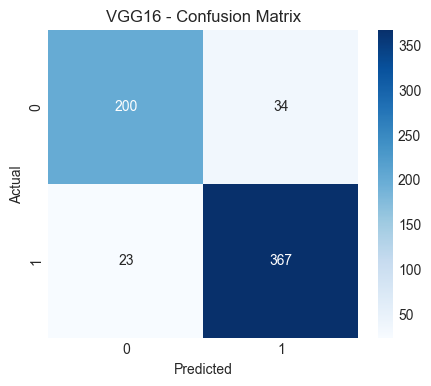

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

for model_name, res in evaluation_results.items():
    cm = res["confusion_matrix"]

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


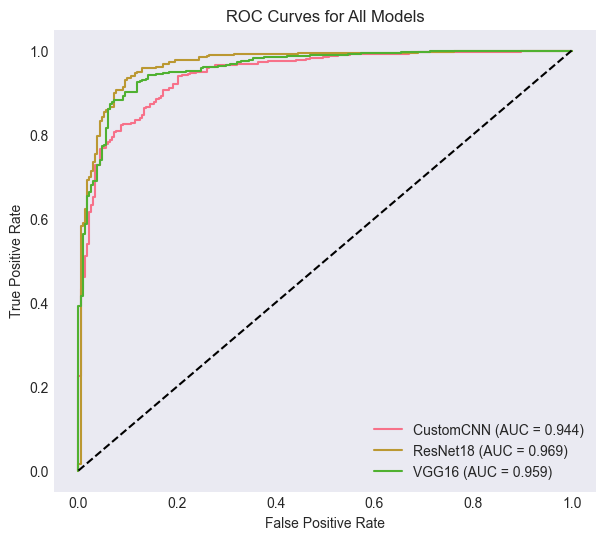

In [66]:
plt.figure(figsize=(7, 6))

for model_name, res in evaluation_results.items():
    fpr = res["fpr"]
    tpr = res["tpr"]
    roc_auc = res["roc_auc"]
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models")
plt.legend()
plt.grid()
plt.show()


## What I Learned

Through this project, I gained several valuable insights about applying deep learning to medical imaging. First, transfer learning is incredibly powerful for small medical datasets – both ResNet18 and VGG16 significantly outperformed my custom CNN trained from scratch, confirming that ImageNet pre-trained features do transfer meaningfully to chest X-ray images despite the domain difference. However, I was surprised that my relatively simple CustomCNN still achieved 82.53% accuracy, demonstrating that you don't always need complex architectures if you design thoughtfully.

I also learned the importance of class imbalance handling in medical applications. Implementing weighted loss functions was crucial – without it, my early experiments showed models that simply predicted "pneumonia" for almost everything. 

Finally, I learned about the limitations of small validation sets firsthand. The 16-image validation set caused extremely noisy training curves.

## What works well

Several approaches proved effective in this project. Data augmentation (horizontal flips, rotations, color jitter) helped combat overfitting and improved generalization, particularly for the CustomCNN which benefited most from the artificially expanded training set. Freezing early layers in transfer learning models was also smart – it preserved general feature detectors while allowing task-specific fine-tuning without requiring massive computational resources. The early stopping mechanism prevented excessive overfitting and saved training time, though I had to increase patience from 1 to 5 epochs after observing premature stopping

## What didn't work

I realized that freezing too many layers might have limited the models' ability to adapt to medical imaging specifics. Keeping only the last 10 parameters trainable was perhaps too conservative – unfreezing more layers might have improved performance. 

## Future Improvements

If I were to continue this project, several enhancements would be valuable. First, addressing the validation set problem by restructuring splits (perhaps 70-20-10 train-val-test) would enable more reliable hyperparameter tuning. 

Second, implementing more sophisticated hyperparameter optimization using techniques like grid search, random search will help further on the test accuracy.

I would also explore ensemble methods – combining predictions from CustomCNN, ResNet18, and VGG16 could potentially achieve better performance than any individual model by leveraging their complementary strengths.

From an architecture perspective, trying more modern architectures like EfficientNet, DenseNet, or Vision Transformers could provide better accuracy-efficiency trade-offs than the older VGG16.